# Import & prep

In [76]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

from functools import lru_cache



In [7]:
ALPHA_VANTAGE_ACCESS_KEY = context.params['alpha_vantage']['access_key']

In [62]:
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.fundamentaldata import FundamentalData
import alpha_vantage

ts = TimeSeries(ALPHA_VANTAGE_ACCESS_KEY)
fd = FundamentalData(ALPHA_VANTAGE_ACCESS_KEY)

In [9]:
@lru_cache()
def historic_eps(symbol):
    response = requests.get(
        f'https://www.alphavantage.co/query?function=EARNINGS&symbol={symbol}&apikey={ALPHA_VANTAGE_ACCESS_KEY}'
    )
    data = response.json()
    if data == {}:
        raise ValueError('Error getting data from the api, no return was given.')
    elif response.status_code == 200:
        return response.json()

# Testing

In [57]:
historic_eps('ISF.LON')

ValueError: Error getting data from the api, no return was given.

In [60]:
raw_isf_daily, isf_meta = ts.get_daily_adjusted('ISF.LON', outputsize='full')

In [61]:
isf_meta

{'1. Information': 'Daily Time Series with Splits and Dividend Events',
 '2. Symbol': 'ISF.LON',
 '3. Last Refreshed': '2021-04-12',
 '4. Output Size': 'Full size',
 '5. Time Zone': 'US/Eastern'}

In [59]:
isf_daily = pd.DataFrame.from_dict(raw_isf_daily, orient='index', dtype='float')
isf_daily.head()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
2021-04-09,684.1,684.1000,679.747,680.5,680.5,5585925.0,0.0,1.0
2021-04-08,679.4,683.3000,677.600,683.3,683.3,9748153.0,0.0,1.0
2021-04-07,673.8,678.1001,672.630,676.6,676.6,10061820.0,0.0,1.0
2021-04-06,671.6,673.0000,668.600,670.7,670.7,11375580.0,0.0,1.0
2021-04-01,662.7,665.7000,661.708,662.9,662.9,7006047.0,0.0,1.0


In [58]:
isf_daily['7. dividend amount'].unique()

array([0.    , 0.0562, 0.0345, 0.0573, 0.0426, 0.0635, 0.0607, 0.0951,
       0.1056, 0.0712, 0.0901, 0.0942, 0.0541, 0.0532, 0.0922, 0.0945,
       0.0615, 0.0505, 0.0788, 0.0884, 0.0478, 0.0865, 0.052 , 0.0946,
       0.0208, 0.0685, 0.0523, 0.0759, 0.0253, 0.0515, 0.0525, 0.0856,
       0.0298, 0.0561, 0.0456, 0.0744, 0.0266, 0.0396, 0.0554, 0.0639,
       0.0224, 0.0322, 0.0342, 0.068 , 0.0274, 0.0344, 0.0434, 0.0555,
       0.0381, 0.0447, 0.0529, 0.0799, 0.0439, 0.0464, 0.0795, 0.0209,
       0.0269, 0.0755, 0.0192, 0.0288, 0.0552, 0.0203])

In [77]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 150 # 200 e.g. is really fine, but slower

In [84]:
isf_daily.sort_index(inplace=True)

<AxesSubplot:ylabel='Density'>

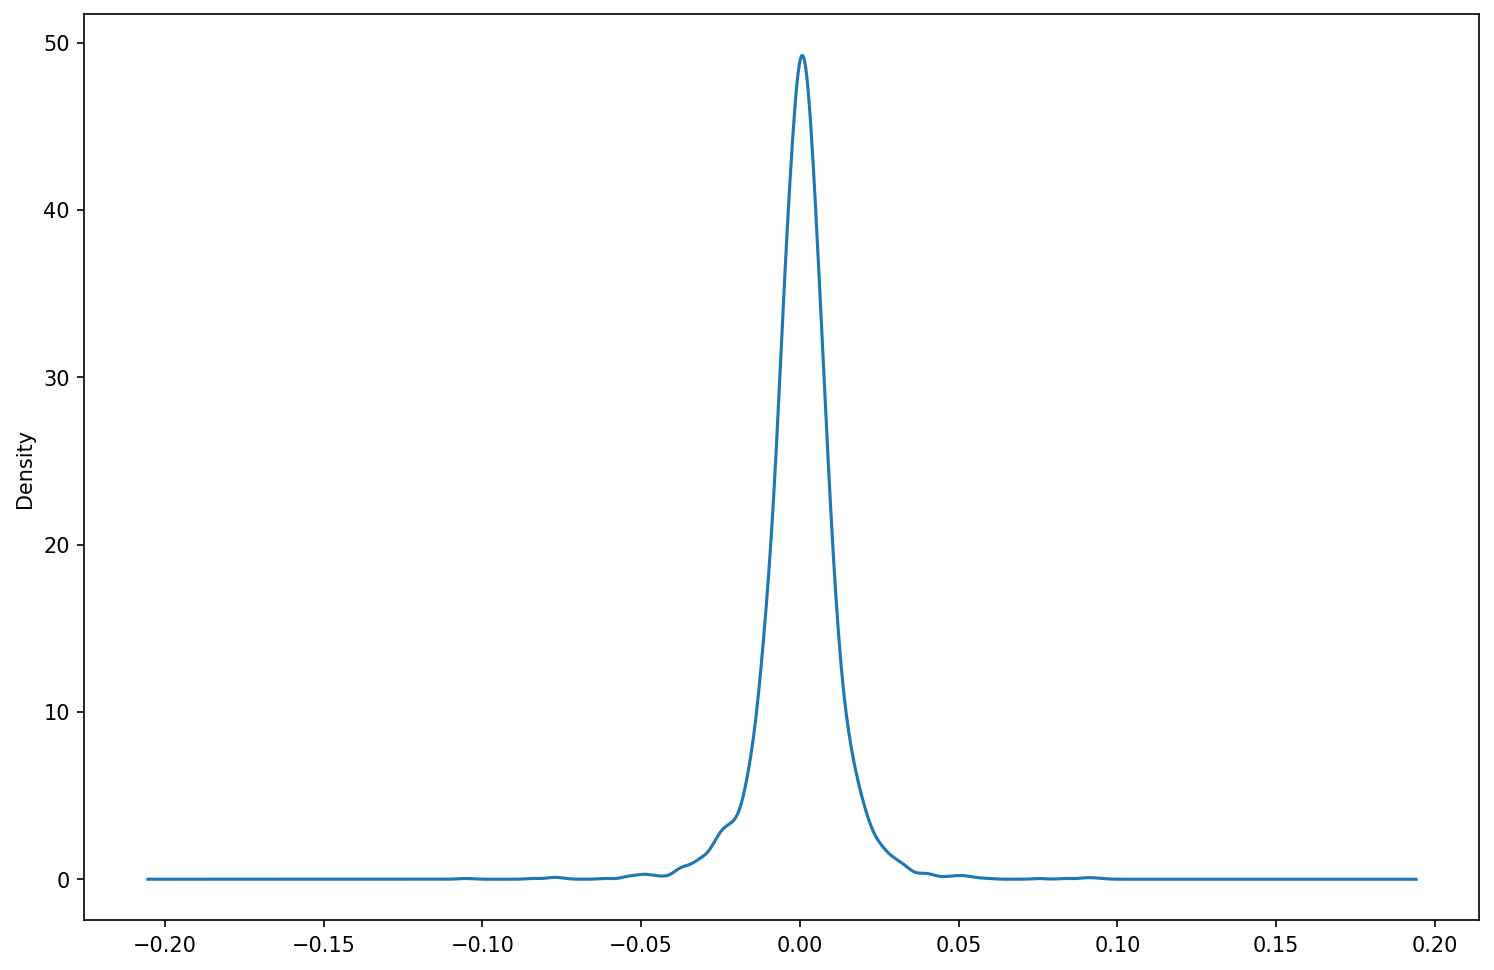

In [125]:
isf_daily['daily'] = isf_daily['5. adjusted close'] / isf_daily['5. adjusted close'].shift(1) - 1
isf_daily['weekly'] = isf_daily['5. adjusted close'] / isf_daily['5. adjusted close'].shift(7) - 1
isf_daily['monthly'] = isf_daily['5. adjusted close'] / isf_daily['5. adjusted close'].shift(30) - 1
isf_daily['annual'] = isf_daily['5. adjusted close'] / isf_daily['5. adjusted close'].shift(365) - 1
isf_daily.daily.plot.density()

In [126]:
isf_daily.daily.max()

0.09421661696035577

In [127]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

print("standard deviation: {:0.4f}".format(np.std(isf_daily['monthly'])))
print("mean absolute deviation: {:0.4f}".format(np.mean(np.absolute(isf_daily['monthly']))))

standard deviation: 0.0537
mean absolute deviation: 0.0395


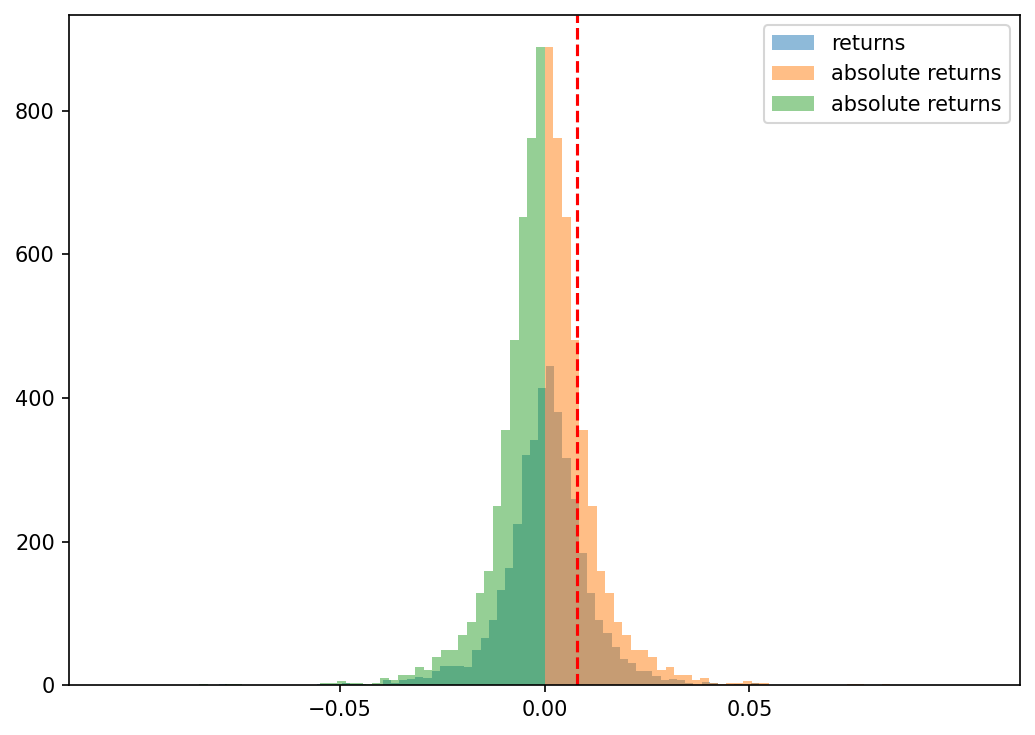

In [128]:
f, ax = plt.subplots(figsize=(7,5))
ax.hist(isf_daily['daily'], alpha=0.5, label=["returns"], bins=100)
ax.hist(np.absolute(isf_daily['daily']), alpha=0.5, label=["absolute returns"], bins=50)
ax.hist(-np.absolute(isf_daily['daily']), alpha=0.5, label=["absolute returns"], bins=50)
ax.axvline(np.absolute(isf_daily['daily']).mean(), linestyle="dashed", color="red")
ax.set_xticks([-0.05,0,0.05])
ax.legend(prop={'size': 10})
f.tight_layout()